In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [ ]:
# Setup folder for data

# Get current working directory
cwd = os.getcwd()

# Set data folder location
data_loc = os.path.join(cwd, "Data")

# Search for data folder
if data_loc not in os.listdir(cwd):

    # Create data folder if not found
    os.makedirs(data_loc)

In [ ]:
#Create a clean data set of a specified size
def create_data(size):

    x_vals = [np.linspace(0, np.random.randint(1,20)*np.pi, 1000) for i in range(size)]
    y_vals = [np.sin(x) for x in x_vals]
    classification = ["Clean" for x in x_vals]
            
    entry = {
        "X": x_vals,
        "Y": y_vals,
        "Classification": classification
    }

    return entry

#Create a noisy array from an array of input x-values
def apply_noise(xarr):
    return [np.sin(x) + np.random.normal(0, 0.5, 1000) for x in xarr]

In [324]:
#Create 50 clean data sets with random periods
data_set = create_data(100)

x_vals = data_set["X"]
y_vals = data_set["Y"]
classification = data_set["Classification"]

#Create a noisy data set and classifier list 
y_vals_noise = apply_noise(x_vals)
classification_noise = ["Noisy" for i in range(len(x_vals))]

data_set["X"] = x_vals + x_vals
data_set["Y"] = y_vals + y_vals_noise
data_set["Classification"] = classification + classification_noise

In [325]:
#Create a pandas dataframe and export to the data location provided above
data = pd.DataFrame(data_set)
data.to_csv(f"{data_loc}/data.csv")

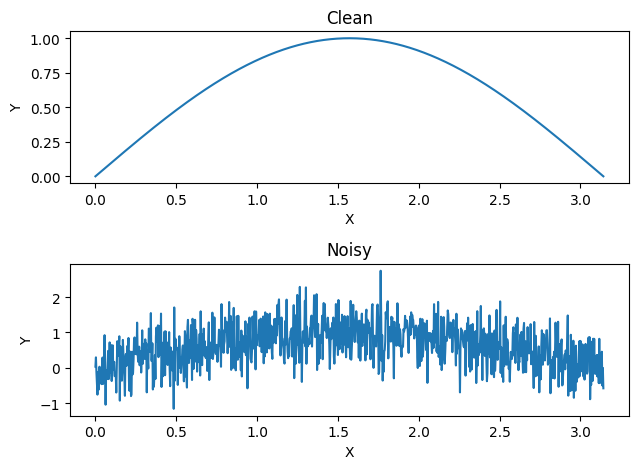

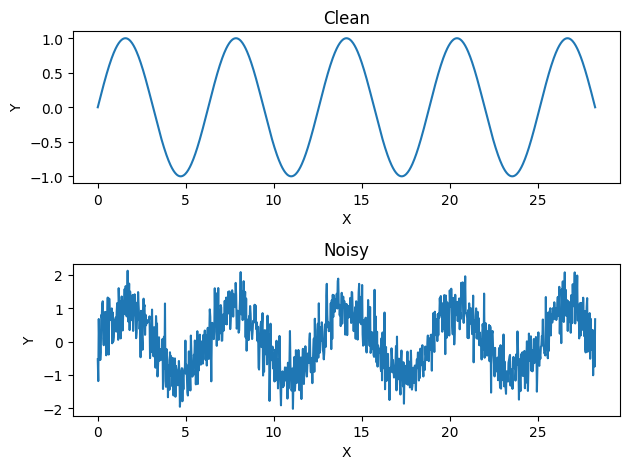

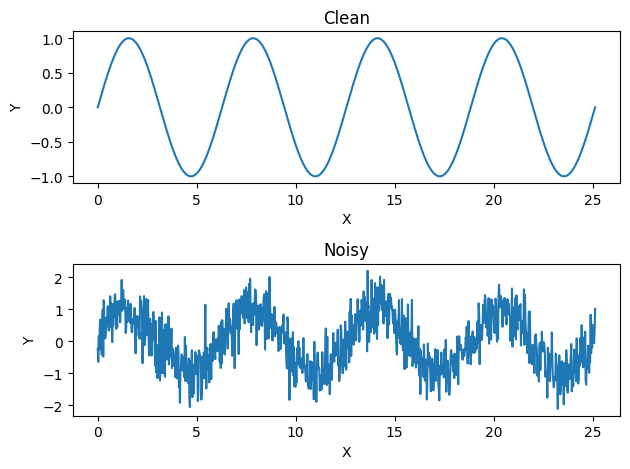

In [329]:
#Load each each column respectively
y_data = np.asarray(data["Y"])
x_data = np.asarray(data["X"])

#Create a random test index list
index = [np.random.randint(1,50) for x in range(3)]

#Loop over the index list and plot the respective noisy and clean functions
for i in index:
    plt.figure()
    plt.subplot(211)
    plt.title("Clean")
    plt.plot(x_data[i], y_data[i])
    plt.xlabel("X")
    plt.ylabel("Y")

    plt.subplot(212)
    plt.title("Noisy")
    plt.plot(x_data[i+100], y_data[i+100])
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.tight_layout()
    plt.show()

In [330]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn import manifold

(200, 1000)


d:\Development\ML\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
d:\Development\ML\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
d:\Development\ML\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


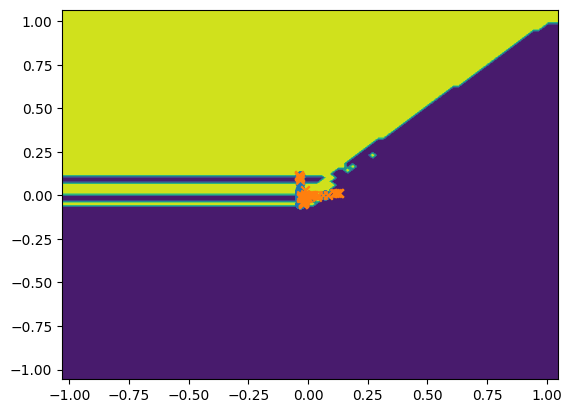

In [332]:
features = np.asarray([y_data[i] for i in range(len(x_data))])
labels = data["Classification"]


print(features.shape)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)

embedding = manifold.SpectralEmbedding(n_components=2, n_neighbors=7)

embedding.fit(X_train)

x_train_transform = embedding.fit_transform(X_train)
x_test_transform = embedding.fit_transform(X_test)

clf = KNeighborsClassifier(n_neighbors=3)

clf.fit(x_train_transform, y_train)


embedded_features = embedding.fit_transform(features)

disp = DecisionBoundaryDisplay.from_estimator(clf, embedded_features, response_method="predict")
disp.ax_.scatter(x_train_transform[:, 0], x_train_transform[:, 1], marker="o")     
disp.ax_.scatter(x_test_transform[:, 0],x_test_transform[:, 1], marker="x")
plt.show()

